Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)


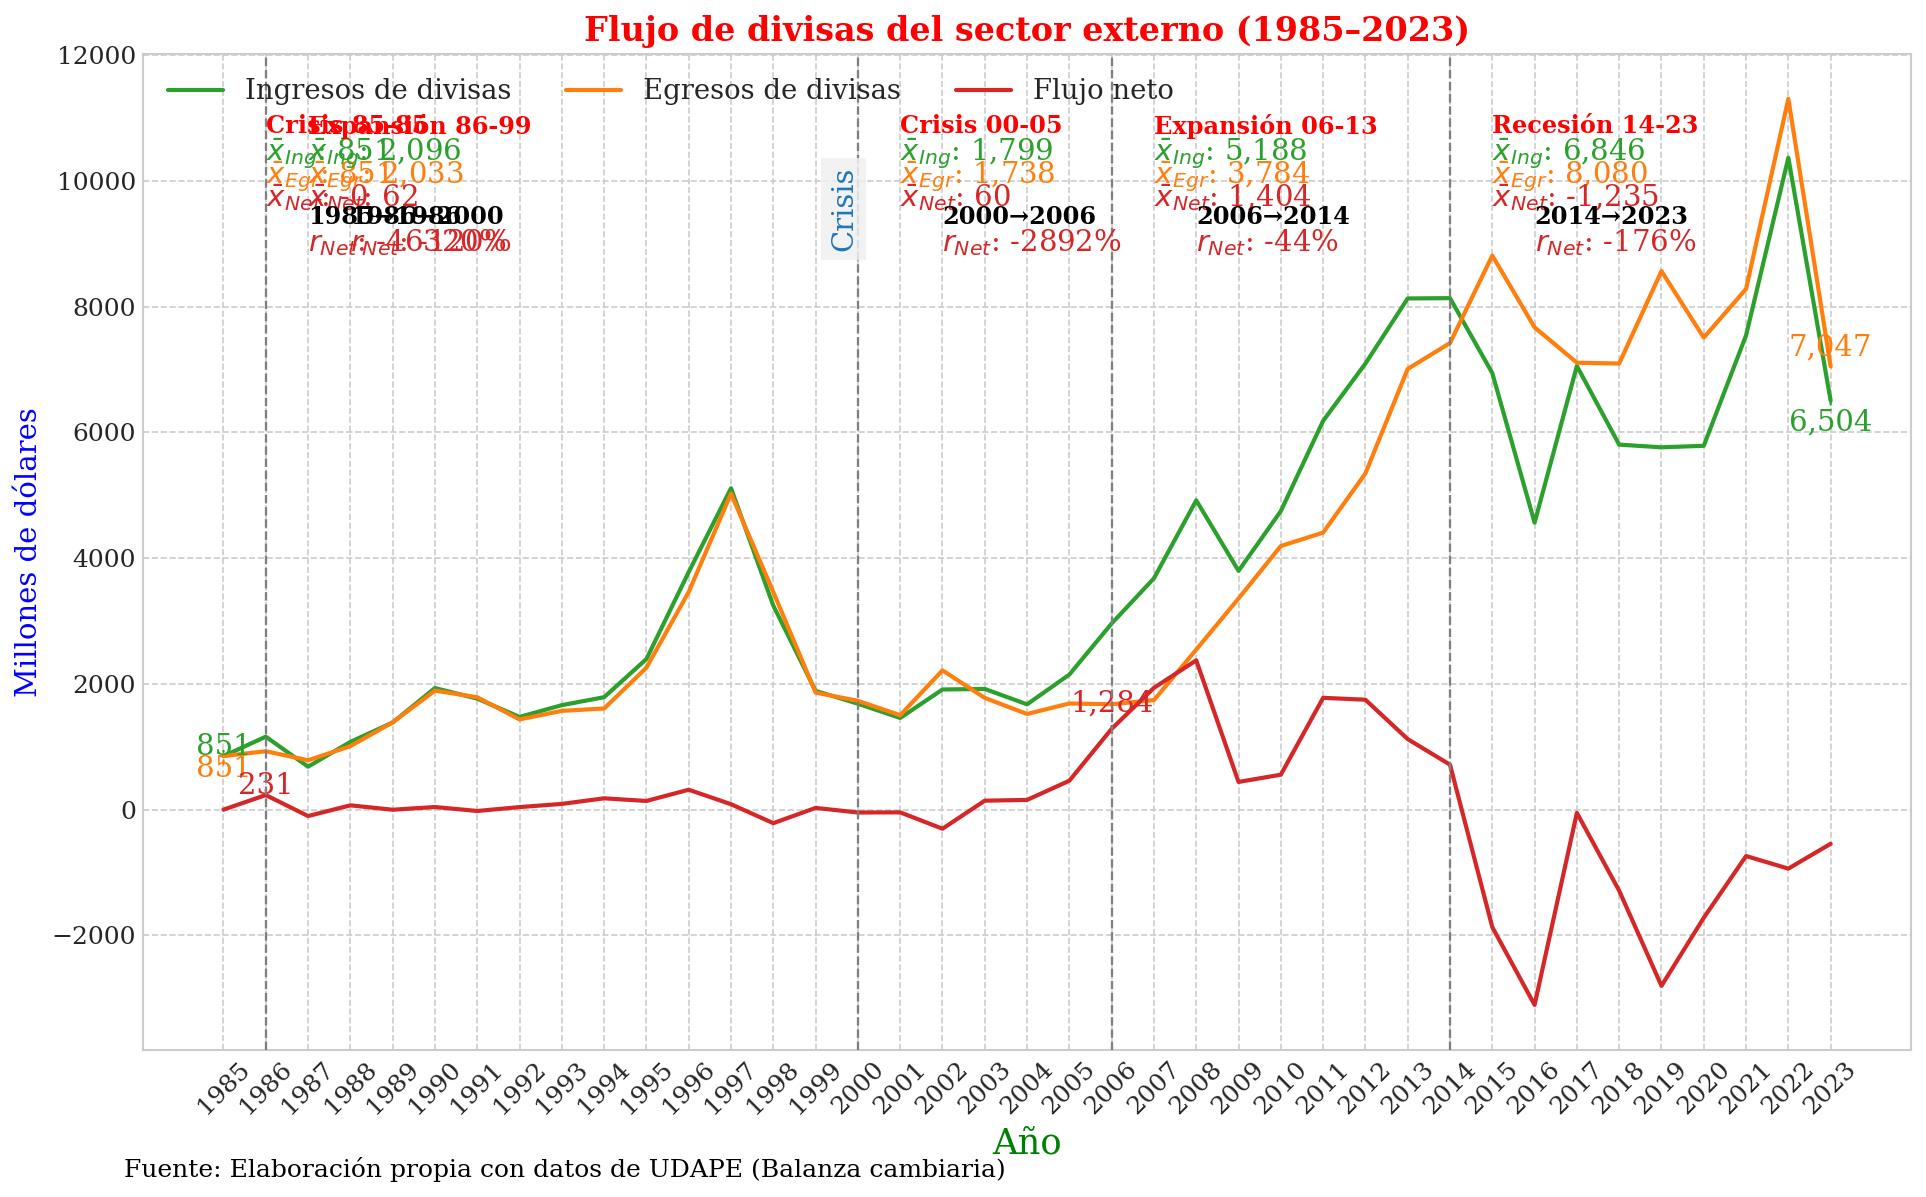

In [ ]:
# ─────────────────────────────────────────────────────────────
# 1. Imports y configuración global                           
# ─────────────────────────────────────────────────────────────
import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))  # utilidades propias
from graficos_utils import *
from config import *

# Directorio de salida
output_dir = "../../../../assets/tesis/serie_completa/sector_externo"
os.makedirs(output_dir, exist_ok=True)

# Estilo global
set_style()

# %%
# ─────────────────────────────────────────────────────────────
# 2. Carga de datos                                           
# ─────────────────────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (
        pd.read_sql('SELECT * FROM flujo_divisas', conn, index_col='año')
          .sort_index()
    )

# %%
# ─────────────────────────────────────────────────────────────
# 3. Componentes, abreviaturas y colores                      
# ─────────────────────────────────────────────────────────────
componentes = [
    ("ingreso_divisas", "Ingresos de divisas"),
    ("egreso_divisas",  "Egresos de divisas"),
    ("flujo_neto_divisas", "Flujo neto")
]
cols_componentes = [c for c, _ in componentes]

abbr = {
    "ingreso_divisas": "Ing",
    "egreso_divisas":  "Egr",
    "flujo_neto_divisas": "Net",
}

cmap = plt.get_cmap("tab10")
colors = {
    "ingreso_divisas": cmap(2),  # verde azulado
    "egreso_divisas":  cmap(1),  # naranja
    "flujo_neto_divisas": cmap(3)  # rojo
}

# %%
# ─────────────────────────────────────────────────────────────
# 4. Preparación de años, ciclos y periodos                   
# ─────────────────────────────────────────────────────────────
annot_years = adjust_annot_years(df, annot_years)
cycles = adjust_cycles(df, CYCLES)
cycle_stats = {
    n: df.loc[s, cols_componentes].mean().to_dict()
    for n, s in cycles.items()
}
periodos = adjust_periods(df, periodos_tasas)

# %%
# ─────────────────────────────────────────────────────────────
# 5. Offsets (borrador inicial, ajustar manualmente)          
# ─────────────────────────────────────────────────────────────
# a) Anotaciones por serie y año  (desplazamientos heurísticos)
annotation_offsets = {
    'ingreso_divisas': {
        1985: (0,  150),  1995: (0,  300),  2005: (0,  350),
        2015: (0,  400),  2023: (0, -350)
    },
    'egreso_divisas': {
        1985: (0, -200),  1995: (0, -300),  2005: (0, -350),
        2015: (0, -400),  2023: (0,  300)
    },
    'flujo_neto_divisas': {
        1986: (0,  150),  1999: (0,  200),  2006: (0,  400),
        2016: (0, -350),  2022: (0, -300)
    }
}

# b) Hitos verticales (reutilizamos los de config)
hitos_offset = {a: 0.85 for a in hitos_v}

# c) Cuadros de medias por ciclo (ubicados arriba del 90 % del eje)
medias_offsets = {
    name: (slice_.start + 1, 0.92) for name, slice_ in cycles.items()
}

# d) Tasas de crecimiento acumuladas por periodo (bloques en 80 %)
tasas_offsets = {
    f"{vi}-{vf}": (vi + 2, 0.80) for vi, vf in periodos
}

# Nota: Para esta gráfica NO se añaden cuadros de participación.

# %%
# ─────────────────────────────────────────────────────────────
# 6. Gráfica                                                   
# ─────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=colors,
    title=f"Flujo de divisas del sector externo ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de dólares",
    source_text="Fuente: Elaboración propia con datos de UDAPE (Balanza cambiaria)"
)

# Hitos verticales
add_hitos(ax, df.index, hitos_v, hitos_offset)

# Anotaciones de valores
add_year_value_annotations(
    ax, df, annot_years,
    cols_componentes, annotation_offsets, colors
)

# Cuadros de medias por ciclo
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.03
add_cycle_means_multi(
    ax, cycle_stats, medias_offsets,
    abbr, colors, line_spacing
)

# Tasas de crecimiento por periodo (solo Flujo neto)
add_period_growth_annotations_multi(
    ax, df, periodos,
    cols=['flujo_neto_divisas'],
    period_offsets=tasas_offsets,
    colors=colors,
    abbr_map={'flujo_neto_divisas': 'Net'},
)

plt.savefig(os.path.join(output_dir, "flujo_divisas.png"))
plt.show()
